In [1]:
import preamble
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import LdaModel
import plotly.express as px
import plotly.io as pio
import textwrap
import src.constants as const
from src.print_topics import print_topics
from tueplots import bundles
from tueplots.constants.color import rgb
import src.constants as const  

In [ ]:
# import lda model and data
df = pd.read_parquet("data/final.parquet")

In [3]:
total_speeches_per_year = df.groupby('year').size().to_dict()

In [4]:
# for panel 1: construct dataframe with dominant topics per year
# select topic with highest probability for each speech
df['dominant_topic_id'] = df.loc[:, 'topic_0':'topic_29'].idxmax(axis=1).apply(lambda x: int(x.split('_')[1])).astype(int)
# give dominant topic its label
df['dominant_topic'] = df['dominant_topic_id'].apply(lambda x: const.TOPIC_LABELS[x])

In [5]:
df_dominant = df.groupby(['dominant_topic', 'year']).agg({
    'text': 'count'}).reset_index().rename(columns={'text': 'count'})

# calculate ratios
df_dominant['total_speeches'] = df_dominant['year'].map(total_speeches_per_year)
df_dominant['ratio'] = df_dominant['count'] / df_dominant['total_speeches']

In [ ]:
def stacked_area_plot(df_dominant, topics):
    # filter for selected topics
    df_plot = df_dominant[df_dominant['dominant_topic'].isin(topics)]

    # pivot dataframe for stacked area plot
    df_pivot = df_plot.pivot(index='year', columns='dominant_topic', values='ratio').fillna(0)
    # df_pivot = df_pivot[topics]    

    # create stacked area plot
    ax = df_pivot.plot.area(cmap="viridis", alpha=0.75)
    ax.set_ylabel('Proportion of Speeches')
    ax.set_xlabel('')

    # reverse legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper left', frameon=True)
    # ax.set_title('Proportion of Speeches by Dominant Topic Over Time')
    ax.set_xlim(df_dominant['year'].min(), df_dominant['year'].max())
    ax.set_ylim(0, 0.37)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.set_axisbelow(True)

    ax.grid(alpha=0.3)
    # despine
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return ax

In [47]:
chosen_topics = [
    "Migration & Asylum",
    "Terror & Political Violence",
    "Climate & Energy",
    "Disasters & Epidemics",
    "Russia & Ukraine"]

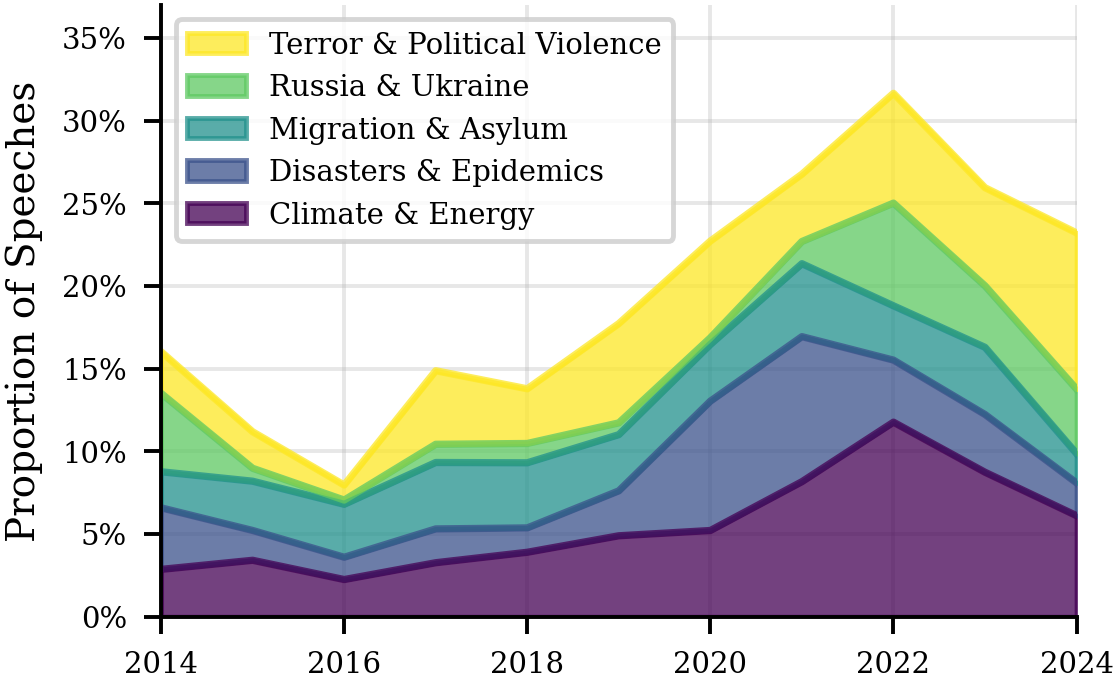

In [63]:
ax = stacked_area_plot(df_dominant, chosen_topics)

In [61]:
# save figure
fig = ax.get_figure()
fig.savefig("report/fig/fig1_panel1.pdf")

In [18]:
# for panel 2: add mask that for every row indicates whether probability of migration topic > threshold
df["migration_mask"] = df[f"topic_{const.MIGRATION_TOPIC_ID}"] > const.MIGRATION_THRESHOLD

df_migration = df[df["migration_mask"]].groupby(['year', 'block']).agg({
    'text': 'count'}).reset_index().rename(columns={'text': 'n_speeches'})

df_migration['total_speeches'] = df_migration['year'].map(total_speeches_per_year)
df_migration['ratio'] = df_migration['n_speeches'] / df_migration['total_speeches']

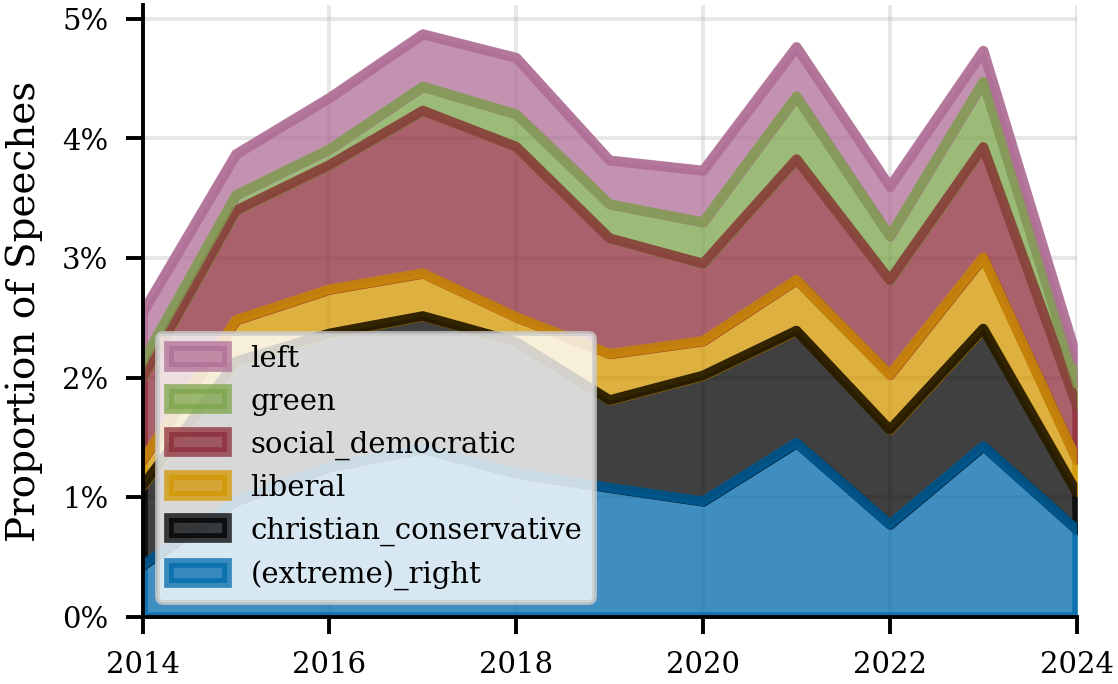

In [64]:
blocks = df_migration['block'].unique()
# sort df_migration by custom block order
blocks = [block for block in const.ORDER_BLOCK if block in blocks]
df_migration['block'] = pd.Categorical(df_migration['block'], categories=blocks, ordered=True)
df_migration = df_migration.sort_values(['year', 'block'])

ax = df_migration.pivot(index='year', columns='block', values='ratio').plot.area(
    stacked=True, 
    color=[const.COLOR_MAP_BLOCK[block] for block in blocks],
    linewidth=2,
    alpha=0.75
)



ax.set_xlabel("")
ax.set_ylabel('Proportion of Speeches')

# ax.set_title("Migration Discourse by Political Block")
# reverse legend order
handles, labels = ax.get_legend_handles_labels()


ax.legend(handles[::-1], labels[::-1], loc='lower left', frameon=True)
ax.set_axisbelow(True)
ax.grid(alpha=0.3)
# ax.vlines(x=const.ELECTION_YEARS, ymin=0, ymax=1, colors='gray', linestyles='dashed', alpha=0.5)
ax.set_xlim(2014, 2024)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


In [65]:
# save figure
fig = ax.get_figure()
fig.savefig("report/fig/fig1_panel2.pdf")